In [1]:
# import the necessary libraries

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data' # Keep all the codes and pre-trained weights in data directory

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [5]:
print (instrs_vocab_size, ingr_vocab_size) 
# print size of each vocabulary in terms of words

23231 1488


In [6]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the pre-trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t) # Find the time required to load the model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 4.09967303276062


In [7]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [8]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [20]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = True # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False # if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs') # demo folder containing the sample images

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

#demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            #'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_urls = ['https://kfoods.com/images1/newrecipeicon/Sada-chawal_1071.jpg']
demo_files = demo_urls if use_urls else demo_imgs

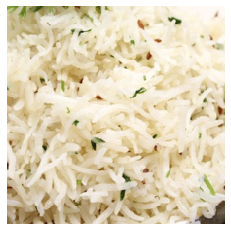

RECIPE 1

Title: Cilantro rice

Ingredients:
rice, salt, water, butter, cilantro, oil

Instructions:
-In a medium saucepan, bring the water to a boil.
-Add the rice and salt and cook over moderate heat, stirring occasionally, until the rice is tender and the water has been absorbed, about 20 minutes.
-Remove from the heat and stir in the butter, cilantro and olive oil.
RECIPE 2

Title: Herbed basmati rice

Ingredients:
rice, salt, water, butter, cilantro, oil

Instructions:
-Melt oil in a large saucepan; add rice, water, 2 teaspoons salt, and 1 teaspoon fresh cilantro.
-Bring to a boil; cover, reduce heat, and simmer 18 minutes, or until liquid is absorbed.
-Fluff rice mixture with a fork.
-Sprinkle with remaining salt.
RECIPE 3

Title: Basmati rice with cilantro

Ingredients:
rice, salt, water, butter, cilantro, oil

Instructions:
-Heat the butter and 2 t oil in a medium saucepan.
-Add the rice and toast for 2 minutes, stirring.
-Stir in the water and salt.
-Bring to a boil, cover and

In [21]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        